For running models, the generic code can be sourced from documentation and DataCamp tutorials, as the only thing needed to be done is feed in data that already existed. However, before that, the most important part is preparing the data and making it usable to deliver the best results out of a model. We will explore this as we go along further.

Import the libraries:

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import dataset that we cleaned and wrangled in a previous notebook:

In [98]:
df = pd.read_csv("diabetes.csv")
df = pd.DataFrame(df)
df.drop(columns = ['Unnamed: 0'])

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_emergency,number_inpatient,number_diagnoses,insulin,change,diabetesMed,readmitted,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male
0,0,1,41,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0
1,1,3,59,0,18,0,0,9,3,1,1,2,0,0,1,0,0,1,0
2,2,2,11,5,13,0,1,6,0,0,1,0,1,0,0,0,0,1,0
3,3,2,44,1,16,0,0,7,3,1,1,0,0,0,1,0,0,0,1
4,4,1,51,0,8,0,0,5,2,1,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99487,7,3,51,0,16,0,0,9,1,1,1,2,1,0,0,0,0,0,1
99488,8,5,33,3,18,0,1,9,2,0,1,0,1,0,0,0,0,1,0
99489,7,1,53,0,9,0,0,13,1,1,1,0,0,0,1,0,0,0,1
99490,8,10,45,2,21,0,1,9,3,1,1,0,0,0,1,0,0,1,0


We pick 'readmitted' as the response variable and everything else as the predictors. We want to predict the chance of readmission based on the other factors. <br>
Readmitted has 3 levels, from 0 to 2, which is ordinal. <br>
Categorical non-ordinal predictors: race, gender, admission source id. Everything else is discrete and ordinal.<br>
So let us use classification over here since the output variable is discrete and labeled.

Let us use penalized (lasso) regression to identify which variables can be removed for further modeling (feature selection).

In [99]:
from sklearn.linear_model import Lasso

names = df.drop('readmitted', axis=1).columns

lasso = Lasso(alpha=0.4)

lasso_coef = lasso.fit(df.drop('readmitted', axis=1), df.readmitted).coef_

Print coefficients to determine which ones are significant:

In [100]:
l2 = lasso_coef
l1 = df.columns[:-1]
p = pd.DataFrame(list(zip(l1, l2))) 
p.columns = [ "Columns", "Coefficients"]
p.loc[(p['Coefficients']!=0)].sort_values(by=['Coefficients'], ascending=False)

,Columns,Coefficients
3,num_lab_procedures,5.749705e-04
0,Unnamed: 0,-7.056020e-07


In [101]:
del p, l1, l2

It seems like the only variables that are significant in determining readmission are numbers of lab tests.

Now create train and test data using only those features.

In [102]:
X = df[[#"number_inpatient", 
        #"number_diagnoses", 
        "num_lab_procedures"
        #"num_medications" , 
        #"num_procedures"
    ]]

y = df['readmitted']

df = pd.concat([X,y], axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

df

,num_lab_procedures,readmitted
0,41,0
1,59,2
2,11,0
3,44,0
4,51,0
...,...,...
99487,51,2
99488,33,0
99489,53,0
99490,45,0


 Let's try KNN.

In [103]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train, y_train)

pred = knn.predict(X_test)

score = knn.score(X_test, y_test)

#Accuracy rate of model
score

from sklearn.metrics import confusion_matrix, classification_report

# confusion_matrix
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred)}\n')

# classification report
print(f'Classification Report: \n{classification_report(y_test, pred)}')

Confusion Matrix:
[[16816   263  4247]
 [ 3515    62   891]
 [10909   204  2890]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     21326
           1       0.12      0.01      0.02      4468
           2       0.36      0.21      0.26     14003

    accuracy                           0.50     39797
   macro avg       0.34      0.34      0.31     39797
weighted avg       0.43      0.50      0.44     39797



Accuracy is very mediocre - only half the time will the model predict the right output.

Use logistic regression:

In [104]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

Run k-fold cross validation:

In [105]:
from sklearn.model_selection import cross_val_score

# Perform k-fold CV
k = 3

k = int(k)

cvscores_k = cross_val_score(log_reg, X, y, cv=k)

print(f'cv=k scores mean: {np.round(np.mean(cvscores_k), k)}')

cv=k scores mean: 0.536


Same problem as with the KNN. Accuracy is only about half.

Run ROC curve:

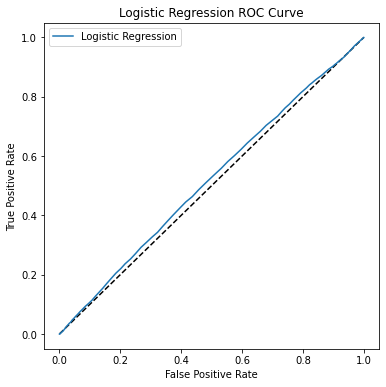

In [106]:
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=2)

plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

Run ridge regression:

In [107]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha=0.5, normalize=True)

ridge_cv = cross_val_score(estimator=ridge, X=X, y=y, cv=5)

ridge_cv

array([ 0.00142819, -0.00979783, -0.03042042, -0.00733701, -0.02942172])

The results from the cross validation scores reflect a disappointing metric of accuracy.

Run a pipeline to center and scale the data before running KNN on it.

In [108]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

steps = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
knn_scaled = pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.47248605457560683

There was no impact on the accuracy of the model even after scaling and centering the data.

Run decision tree:

In [109]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(estimator=tree, param_distributions=param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
bp = tree_cv.best_params_
bs = round(tree_cv.best_score_, 2)

print(f"Tuned Decision Tree Parameters: {bp}") 
print(f"Best score is {bs}")

C:\Users\kapad\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kapad\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kapad\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 903, in fit
    super().fit(
  File "C:\Users\kapad\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 289, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, n_features]

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\kapad\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameter

C:\Users\kapad\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kapad\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kapad\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 903, in fit
    super().fit(
  File "C:\Users\kapad\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 289, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, n_features]

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\kapad\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameter

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 6}
Best score is 0.54


C:\Users\kapad\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kapad\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kapad\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 903, in fit
    super().fit(
  File "C:\Users\kapad\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 289, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, n_features]

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\kapad\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameter

Same here...

Run random forest:

In [110]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# define the model
model = RandomForestClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.536 (0.000)


And here...

Save KNN model:

In [111]:
# save the model to disk
import pickle

# Save the trained model as a pickle string.
saved_model = pickle.dumps(knn)
 
# Load the pickled model
knn_from_pickle = pickle.loads(saved_model)

Conclusion:<br>
Overall, the performance of the models we ran were relatively disappointing, given the accuracy rates being mediocre. This clearly results from the way the data was prepared before being fed into the models. Reasons for that could include:<br>

-- Most of the variables were categorical, mostly binary or had dozens or hundreds of non-ordinal levels. Very few of them were ordinal and numeric, and even those were essentially categorical with small ranges and the mode value being a lower-end value that denied the variable of variance and heavily biased it, causing underfitting. Hence, we delivered low accuracy rates no matter which model we used. We could not use imputation, standardization (centering and scaling) therefore since one variable had 98 percent missing values and the other two with a few missing values were non-ordinal, so we could not have calculated a normal distribution for those to solve it. This is in contrary to other models applied on datasets like Boston Housing Data and Wine Quality, where the response and most predictors themselves were continuous numeric and thus these data preprocessing methods were applicable even with imperfections in data.